In [1]:
import torch
from torch import nn
import torchvision
from torchvision import transforms

In [2]:
transform = transforms.Compose([transforms.ToTensor()])
train_dataset = torchvision.datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = torchvision.datasets.FashionMNIST(root='./data', train=False, download=True, transform=transform)

In [3]:
from torch.utils.data import DataLoader

In [4]:
def dataloader(train_dataset, test_dataset, batch_size):
    return (
        DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True), 
        DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False),
        train_dataset.classes
    )

In [5]:
BATCH_SIZE = 64
train_dataloader, test_dataloader, class_names = dataloader(train_dataset, test_dataset, BATCH_SIZE)

In [6]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [7]:
# new conv
def conv(ni, nf, ks=3, stride=2, act=nn.ReLU, norm=None, bias=None):
    if bias is None: bias = not isinstance(norm, (nn.BatchNorm1d,nn.BatchNorm2d,nn.BatchNorm3d))
    layers = [nn.Conv2d(ni, nf, stride=stride, kernel_size=ks, padding=ks//2, bias=bias)]
    if norm: layers.append(norm(nf))
    if act: layers.append(act())
    return nn.Sequential(*layers)

In [8]:
def get_model(act=nn.ReLU, nfs=(8,16,32,64,128), norm=nn.BatchNorm2d):
    layers = [conv(1, 8, stride=1, act=act, norm=norm)]
    layers += [conv(nfs[i], nfs[i+1], act=act, norm=norm) for i in range(len(nfs)-1)]
    return nn.Sequential(
        *layers, 
        conv(nfs[-1], 10, act=None, norm=norm, bias=True), 
        nn.Flatten()
    ).to(device)

In [9]:
model = get_model(norm=nn.BatchNorm2d)

In [10]:
lr = 6e-2
epochs = 5
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(params=model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=lr, total_steps=epochs*len(train_dataloader))

In [11]:
# in utils.py
import matplotlib.pyplot as plt
def plot_curves(results):
    epochs = range(len(results["train_loss"]))

    plt.figure(figsize=(15, 6))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, results["train_loss"], label="Train Loss")
    plt.plot(epochs, results["test_loss"], label="Test Loss")
    plt.title("Loss")
    plt.xlabel("Epochs")
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(epochs, results["train_acc"], label="Train Accuracy")
    plt.plot(epochs, results["test_acc"], label="Test Accuracy")
    plt.title("Accuracy")
    plt.xlabel("Epochs")
    plt.legend()
    plt.show()

In [12]:
# in train.py
from tqdm.notebook import trange
from IPython.display import display
from torcheval.metrics import MulticlassAccuracy, Mean

class Learner:
    def __init__(self, model, train_dataloader, test_dataloader, loss_fn, optimizer, scheduler, device):
        self.model = model
        self.train_dataloader = train_dataloader
        self.test_dataloader = test_dataloader
        self.loss_fn = loss_fn
        self.optimizer = optimizer
        self.scheduler = scheduler
        self.device = device
        self.loss_metric = Mean(device=device)
        self.accuracy_metric = MulticlassAccuracy(device=device)
        self.results = {
            "train_loss": [],
            "train_acc": [],
            "test_loss": [],
            "test_acc": []
        }
    
    def _update_results(self):
        self.loss_metric.update(self.loss)
        self.accuracy_metric.update(self.pred, self.y)
        
    def _compute_results(self):
        lm = self.loss_metric.compute().item()
        am = self.accuracy_metric.compute().item()
        if self.training:
            mode = "train"
            self.results["train_loss"].append(lm)
            self.results["train_acc"].append(am)
        else:
            mode = "test"
            self.results["test_loss"].append(lm)
            self.results["test_acc"].append(am)
        self.loss_metric.reset()
        self.accuracy_metric.reset()
        print(f"{self.epoch}\t{mode}\t{lm:.4f}\t{am:.4f}")

    def _run_batch(self):
        self.pred = self.model(self.X)
        self.loss = self.loss_fn(self.pred, self.y)
        self._update_results()
        if self.training:
            self.optimizer.zero_grad()
            self.loss.backward()
            self.optimizer.step()

    def _run_epoch(self, train=True):
        self.training = train
        self.dl = self.train_dataloader if self.training else self.test_dataloader
        for self.X, self.y in self.dl:
            self.X, self.y = self.X.to(device), self.y.to(device)
            self._run_batch()
        self._compute_results()
            
    def fit(self, epochs, train=True, test=True):
        self.epochs = epochs
        self.model.to(self.device)
        
        progress_bar = trange(self.epochs, desc="Progress")
        display(progress_bar)
        print("Epoch\tMode\tLoss\tAccuracy")
        
        for self.epoch in progress_bar:
            if train:
                self.model.train()
                self._run_epoch(True)
            if test: 
                self.model.eval()
                with torch.inference_mode(): 
                    self._run_epoch(False)
            self.scheduler.step()
        
        return self.results


d:\Machine Learning\pytorch\lib\site-packages\torchaudio\backend\utils.py:74: UserWarning: No audio backend is available.
  warnings.warn("No audio backend is available.")


In [13]:
learn = Learner(model=model, train_dataloader=train_dataloader, test_dataloader=test_dataloader, loss_fn=loss_fn, optimizer=optimizer, scheduler=scheduler, device=device)
results = learn.fit(5)

Progress:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch	Mode	Loss	Accuracy
0	train	0.4840	0.8598
0	test	0.3282	0.8940
1	train	0.3137	0.8956
1	test	0.2986	0.8933
2	train	0.2695	0.9063
2	test	0.2665	0.9075
3	train	0.2380	0.9182
3	test	0.2659	0.9045
4	train	0.2136	0.9263
4	test	0.2534	0.9091


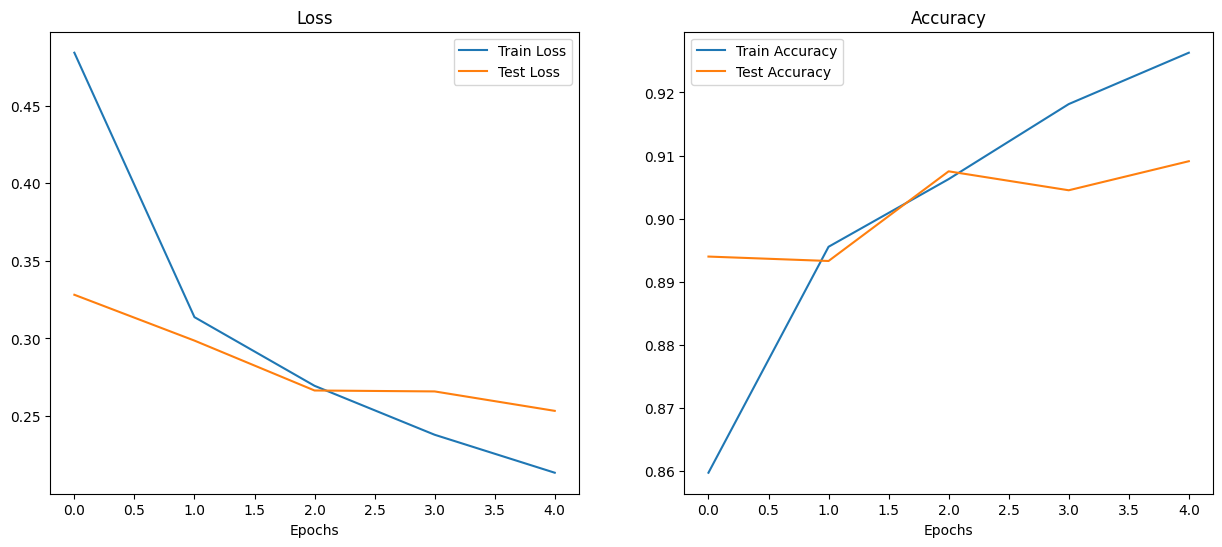

In [14]:
plot_curves(results)